# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param image_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    
    train_path = './' + data_dir + 'train'
    test_path = './' + data_dir + 'test'
    
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)
    
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=0)
    #test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader#, test_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

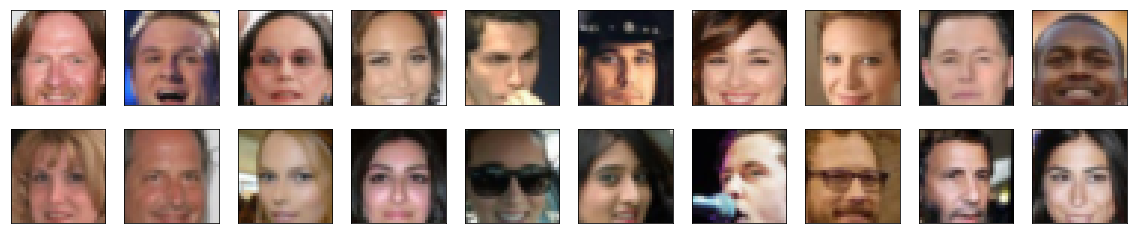

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.9294)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optical batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        #self.conv5 = conv(conv_dim*8, 1, 2, stride=1, padding=0, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.conv_dim*8*2*2)
        return self.fc(x)
        #x = self.conv5(x)
        #print(x.shape)
        #x = x.view(-1, 1)
        #return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected + reshape
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # last layer + tanh activation
        x = self.t_conv4(x)
        return torch.tanh(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m, init_type='normal', init_gain=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            nn.init.normal_(m.weight.data, 0.0, init_gain)
        elif init_type == 'xavier':
            nn.init.xavier_normal_(m.weight.data, gain=init_gain)
        elif init_type == 'kaiming':
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            nn.init.orthogonal_(m.weight.data, gain=init_gain)
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, init_gain)
        nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3685 | g_loss: 0.9774
Epoch [    1/   50] | d_loss: 0.0665 | g_loss: 5.0186
Epoch [    1/   50] | d_loss: 1.0163 | g_loss: 7.5769
Epoch [    1/   50] | d_loss: 0.8934 | g_loss: 3.3518
Epoch [    1/   50] | d_loss: 0.1873 | g_loss: 3.7612
Epoch [    1/   50] | d_loss: 0.1668 | g_loss: 3.2319
Epoch [    1/   50] | d_loss: 0.4573 | g_loss: 3.7608
Epoch [    1/   50] | d_loss: 0.2792 | g_loss: 3.3168
Epoch [    1/   50] | d_loss: 0.7400 | g_loss: 3.1821
Epoch [    1/   50] | d_loss: 0.1866 | g_loss: 3.0431
Epoch [    1/   50] | d_loss: 0.4582 | g_loss: 3.5130
Epoch [    1/   50] | d_loss: 0.6579 | g_loss: 2.5176
Epoch [    1/   50] | d_loss: 0.7007 | g_loss: 2.2948
Epoch [    1/   50] | d_loss: 2.3599 | g_loss: 4.8804
Epoch [    1/   50] | d_loss: 0.4953 | g_loss: 3.7276
Epoch [    1/   50] | d_loss: 0.3323 | g_loss: 3.6602
Epoch [    1/   50] | d_loss: 0.2578 | g_loss: 2.8825
Epoch [    1/   50] | d_loss: 0.3959 | g_loss: 4.8887
Epoch [    1/   50] | d_loss

Epoch [    5/   50] | d_loss: 0.4156 | g_loss: 4.6631
Epoch [    5/   50] | d_loss: 0.4014 | g_loss: 1.6647
Epoch [    5/   50] | d_loss: 0.8067 | g_loss: 2.5856
Epoch [    5/   50] | d_loss: 0.2112 | g_loss: 1.2852
Epoch [    5/   50] | d_loss: 0.5514 | g_loss: 3.8591
Epoch [    5/   50] | d_loss: 0.4476 | g_loss: 1.7472
Epoch [    5/   50] | d_loss: 0.4994 | g_loss: 2.1452
Epoch [    5/   50] | d_loss: 1.0077 | g_loss: 2.2609
Epoch [    5/   50] | d_loss: 0.4650 | g_loss: 4.6664
Epoch [    5/   50] | d_loss: 0.4069 | g_loss: 5.4537
Epoch [    5/   50] | d_loss: 0.5356 | g_loss: 2.6977
Epoch [    5/   50] | d_loss: 0.3147 | g_loss: 3.5981
Epoch [    5/   50] | d_loss: 0.1806 | g_loss: 1.8005
Epoch [    6/   50] | d_loss: 1.3832 | g_loss: 4.6600
Epoch [    6/   50] | d_loss: 0.1866 | g_loss: 3.4296
Epoch [    6/   50] | d_loss: 0.3934 | g_loss: 1.8881
Epoch [    6/   50] | d_loss: 1.3026 | g_loss: 0.3884
Epoch [    6/   50] | d_loss: 0.1897 | g_loss: 2.2162
Epoch [    6/   50] | d_loss

Epoch [   10/   50] | d_loss: 0.1747 | g_loss: 2.7924
Epoch [   10/   50] | d_loss: 0.2607 | g_loss: 4.0148
Epoch [   10/   50] | d_loss: 0.2360 | g_loss: 4.0698
Epoch [   10/   50] | d_loss: 0.0479 | g_loss: 7.0876
Epoch [   10/   50] | d_loss: 0.6741 | g_loss: 1.7753
Epoch [   10/   50] | d_loss: 0.6878 | g_loss: 1.6108
Epoch [   10/   50] | d_loss: 0.8838 | g_loss: 3.7946
Epoch [   10/   50] | d_loss: 0.1661 | g_loss: 3.5669
Epoch [   10/   50] | d_loss: 0.4904 | g_loss: 1.8903
Epoch [   10/   50] | d_loss: 0.4935 | g_loss: 4.1458
Epoch [   10/   50] | d_loss: 0.3461 | g_loss: 3.9873
Epoch [   10/   50] | d_loss: 0.1413 | g_loss: 5.0330
Epoch [   10/   50] | d_loss: 0.3123 | g_loss: 2.1999
Epoch [   10/   50] | d_loss: 0.1737 | g_loss: 3.5133
Epoch [   10/   50] | d_loss: 0.1796 | g_loss: 3.3754
Epoch [   10/   50] | d_loss: 0.5548 | g_loss: 2.1708
Epoch [   10/   50] | d_loss: 0.1350 | g_loss: 5.8126
Epoch [   10/   50] | d_loss: 0.2361 | g_loss: 3.1164
Epoch [   10/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.1266 | g_loss: 6.0202
Epoch [   14/   50] | d_loss: 0.0722 | g_loss: 1.6580
Epoch [   14/   50] | d_loss: 0.0765 | g_loss: 3.7028
Epoch [   14/   50] | d_loss: 0.0608 | g_loss: 3.5751
Epoch [   14/   50] | d_loss: 0.0840 | g_loss: 2.1442
Epoch [   14/   50] | d_loss: 0.0268 | g_loss: 3.9489
Epoch [   15/   50] | d_loss: 0.4423 | g_loss: 3.5208
Epoch [   15/   50] | d_loss: 0.9925 | g_loss: 2.4159
Epoch [   15/   50] | d_loss: 0.0474 | g_loss: 6.7089
Epoch [   15/   50] | d_loss: 0.3508 | g_loss: 2.1532
Epoch [   15/   50] | d_loss: 0.6903 | g_loss: 5.5114
Epoch [   15/   50] | d_loss: 0.0609 | g_loss: 4.4748
Epoch [   15/   50] | d_loss: 0.3381 | g_loss: 0.7582
Epoch [   15/   50] | d_loss: 0.1458 | g_loss: 5.3554
Epoch [   15/   50] | d_loss: 0.1284 | g_loss: 2.5556
Epoch [   15/   50] | d_loss: 0.1395 | g_loss: 4.3836
Epoch [   15/   50] | d_loss: 0.0597 | g_loss: 6.6880
Epoch [   15/   50] | d_loss: 0.0671 | g_loss: 5.2736
Epoch [   15/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.2280 | g_loss: 2.3612
Epoch [   19/   50] | d_loss: 0.0063 | g_loss: 8.2873
Epoch [   19/   50] | d_loss: 0.0570 | g_loss: 5.8570
Epoch [   19/   50] | d_loss: 0.1463 | g_loss: 3.6421
Epoch [   19/   50] | d_loss: 0.0910 | g_loss: 4.2767
Epoch [   19/   50] | d_loss: 0.1092 | g_loss: 5.0314
Epoch [   19/   50] | d_loss: 0.0370 | g_loss: 5.5143
Epoch [   19/   50] | d_loss: 0.0891 | g_loss: 5.9782
Epoch [   19/   50] | d_loss: 0.1438 | g_loss: 3.2461
Epoch [   19/   50] | d_loss: 0.0450 | g_loss: 4.1016
Epoch [   19/   50] | d_loss: 1.6211 | g_loss: 5.1751
Epoch [   19/   50] | d_loss: 0.0303 | g_loss: 2.3205
Epoch [   19/   50] | d_loss: 0.0509 | g_loss: 5.5797
Epoch [   19/   50] | d_loss: 0.1550 | g_loss: 5.2773
Epoch [   19/   50] | d_loss: 0.1655 | g_loss: 1.3765
Epoch [   19/   50] | d_loss: 0.1486 | g_loss: 2.0185
Epoch [   19/   50] | d_loss: 0.0238 | g_loss: 5.4024
Epoch [   19/   50] | d_loss: 0.1850 | g_loss: 5.2964
Epoch [   19/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0366 | g_loss: 4.0461
Epoch [   24/   50] | d_loss: 0.0604 | g_loss: 5.0702
Epoch [   24/   50] | d_loss: 0.4139 | g_loss: 2.4935
Epoch [   24/   50] | d_loss: 0.0416 | g_loss: 8.2961
Epoch [   24/   50] | d_loss: 0.0188 | g_loss: 3.0311
Epoch [   24/   50] | d_loss: 0.2748 | g_loss: 3.1689
Epoch [   24/   50] | d_loss: 0.0139 | g_loss: 5.1384
Epoch [   24/   50] | d_loss: 0.0259 | g_loss: 4.5906
Epoch [   24/   50] | d_loss: 0.1238 | g_loss: 2.3401
Epoch [   24/   50] | d_loss: 0.6619 | g_loss: 4.1303
Epoch [   24/   50] | d_loss: 0.0961 | g_loss: 2.1992
Epoch [   24/   50] | d_loss: 0.0117 | g_loss: 3.7542
Epoch [   24/   50] | d_loss: 0.7232 | g_loss: 6.0854
Epoch [   24/   50] | d_loss: 0.0228 | g_loss: 6.9146
Epoch [   24/   50] | d_loss: 0.0461 | g_loss: 6.6327
Epoch [   24/   50] | d_loss: 0.0185 | g_loss: 7.1180
Epoch [   24/   50] | d_loss: 0.1325 | g_loss: 4.7340
Epoch [   24/   50] | d_loss: 0.5503 | g_loss: 3.6018
Epoch [   24/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.1865 | g_loss: 2.3469
Epoch [   28/   50] | d_loss: 0.0085 | g_loss: 6.0671
Epoch [   28/   50] | d_loss: 0.0099 | g_loss: 2.2870
Epoch [   28/   50] | d_loss: 0.2924 | g_loss: 6.2557
Epoch [   28/   50] | d_loss: 0.0342 | g_loss: 4.1723
Epoch [   28/   50] | d_loss: 0.9992 | g_loss: 3.4760
Epoch [   28/   50] | d_loss: 0.6395 | g_loss: 1.5201
Epoch [   28/   50] | d_loss: 0.0827 | g_loss: 2.0070
Epoch [   28/   50] | d_loss: 0.4085 | g_loss: 4.8018
Epoch [   28/   50] | d_loss: 0.1732 | g_loss: 4.5978
Epoch [   28/   50] | d_loss: 0.4160 | g_loss: 2.8807
Epoch [   28/   50] | d_loss: 0.0856 | g_loss: 1.4352
Epoch [   29/   50] | d_loss: 0.0339 | g_loss: 5.5449
Epoch [   29/   50] | d_loss: 0.2184 | g_loss: 6.4618
Epoch [   29/   50] | d_loss: 1.8477 | g_loss: 3.6113
Epoch [   29/   50] | d_loss: 2.2502 | g_loss: 7.4961
Epoch [   29/   50] | d_loss: 0.0466 | g_loss: 5.2080
Epoch [   29/   50] | d_loss: 0.3743 | g_loss: 1.0830
Epoch [   29/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0608 | g_loss: 5.0803
Epoch [   33/   50] | d_loss: 0.0417 | g_loss: 1.7887
Epoch [   33/   50] | d_loss: 0.3529 | g_loss: 6.6787
Epoch [   33/   50] | d_loss: 0.0611 | g_loss: 3.9340
Epoch [   33/   50] | d_loss: 0.0072 | g_loss: 5.3348
Epoch [   33/   50] | d_loss: 0.2529 | g_loss: 5.0484
Epoch [   33/   50] | d_loss: 0.1566 | g_loss: 5.8733
Epoch [   33/   50] | d_loss: 0.2085 | g_loss: 5.9746
Epoch [   33/   50] | d_loss: 0.0825 | g_loss: 1.8636
Epoch [   33/   50] | d_loss: 0.1432 | g_loss: 5.0004
Epoch [   33/   50] | d_loss: 0.3523 | g_loss: 1.8906
Epoch [   33/   50] | d_loss: 0.2266 | g_loss: 2.5776
Epoch [   33/   50] | d_loss: 0.0100 | g_loss: 4.7779
Epoch [   33/   50] | d_loss: 0.2672 | g_loss: 4.7385
Epoch [   33/   50] | d_loss: 0.0175 | g_loss: 2.5665
Epoch [   33/   50] | d_loss: 0.0141 | g_loss: 7.3834
Epoch [   33/   50] | d_loss: 0.0218 | g_loss: 7.8171
Epoch [   33/   50] | d_loss: 0.1238 | g_loss: 2.7228
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0888 | g_loss: 8.8312
Epoch [   37/   50] | d_loss: 0.0296 | g_loss: 4.5944
Epoch [   37/   50] | d_loss: 0.1772 | g_loss: 5.6484
Epoch [   37/   50] | d_loss: 0.9856 | g_loss: 5.1428
Epoch [   37/   50] | d_loss: 0.0398 | g_loss: 6.7061
Epoch [   38/   50] | d_loss: 0.1692 | g_loss: 5.6741
Epoch [   38/   50] | d_loss: 0.2348 | g_loss: 5.5855
Epoch [   38/   50] | d_loss: 0.0117 | g_loss: 4.5076
Epoch [   38/   50] | d_loss: 0.0908 | g_loss: 2.2270
Epoch [   38/   50] | d_loss: 0.0147 | g_loss: 6.2922
Epoch [   38/   50] | d_loss: 0.0080 | g_loss: 6.4620
Epoch [   38/   50] | d_loss: 0.0235 | g_loss: 7.0809
Epoch [   38/   50] | d_loss: 0.0286 | g_loss: 4.2749
Epoch [   38/   50] | d_loss: 0.0154 | g_loss: 4.1582
Epoch [   38/   50] | d_loss: 0.0309 | g_loss: 10.0273
Epoch [   38/   50] | d_loss: 0.2077 | g_loss: 5.9925
Epoch [   38/   50] | d_loss: 0.5250 | g_loss: 4.9151
Epoch [   38/   50] | d_loss: 0.0396 | g_loss: 5.9190
Epoch [   38/   50] | d_los

Epoch [   42/   50] | d_loss: 0.1282 | g_loss: 9.5215
Epoch [   42/   50] | d_loss: 0.0152 | g_loss: 6.4220
Epoch [   42/   50] | d_loss: 0.0165 | g_loss: 3.2249
Epoch [   42/   50] | d_loss: 0.0358 | g_loss: 4.6308
Epoch [   42/   50] | d_loss: 0.5261 | g_loss: 3.1083
Epoch [   42/   50] | d_loss: 0.7821 | g_loss: 3.7116
Epoch [   42/   50] | d_loss: 0.0244 | g_loss: 5.7797
Epoch [   42/   50] | d_loss: 0.1688 | g_loss: 5.7442
Epoch [   42/   50] | d_loss: 0.1044 | g_loss: 2.4341
Epoch [   42/   50] | d_loss: 0.0863 | g_loss: 5.5686
Epoch [   42/   50] | d_loss: 0.0336 | g_loss: 5.5533
Epoch [   42/   50] | d_loss: 0.1789 | g_loss: 5.8382
Epoch [   42/   50] | d_loss: 0.4708 | g_loss: 2.4849
Epoch [   42/   50] | d_loss: 0.0125 | g_loss: 5.6102
Epoch [   42/   50] | d_loss: 0.0519 | g_loss: 2.0605
Epoch [   42/   50] | d_loss: 0.3998 | g_loss: 4.4214
Epoch [   42/   50] | d_loss: 0.0168 | g_loss: 5.7034
Epoch [   42/   50] | d_loss: 0.1720 | g_loss: 5.8254
Epoch [   43/   50] | d_loss

Epoch [   47/   50] | d_loss: 1.5159 | g_loss: 1.7643
Epoch [   47/   50] | d_loss: 0.7253 | g_loss: 3.0481
Epoch [   47/   50] | d_loss: 0.0383 | g_loss: 3.7072
Epoch [   47/   50] | d_loss: 0.0793 | g_loss: 4.6797
Epoch [   47/   50] | d_loss: 0.0784 | g_loss: 2.9886
Epoch [   47/   50] | d_loss: 0.0329 | g_loss: 4.6161
Epoch [   47/   50] | d_loss: 0.0042 | g_loss: 6.6713
Epoch [   47/   50] | d_loss: 0.0556 | g_loss: 5.8805
Epoch [   47/   50] | d_loss: 0.0050 | g_loss: 8.5015
Epoch [   47/   50] | d_loss: 0.3145 | g_loss: 4.2434
Epoch [   47/   50] | d_loss: 0.0088 | g_loss: 2.0701
Epoch [   47/   50] | d_loss: 0.0089 | g_loss: 7.2338
Epoch [   47/   50] | d_loss: 0.0027 | g_loss: 7.7152
Epoch [   47/   50] | d_loss: 0.0104 | g_loss: 7.3534
Epoch [   47/   50] | d_loss: 0.0157 | g_loss: 5.1367
Epoch [   47/   50] | d_loss: 0.0632 | g_loss: 4.1272
Epoch [   47/   50] | d_loss: 0.0550 | g_loss: 3.2878
Epoch [   47/   50] | d_loss: 0.0251 | g_loss: 3.6876
Epoch [   47/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

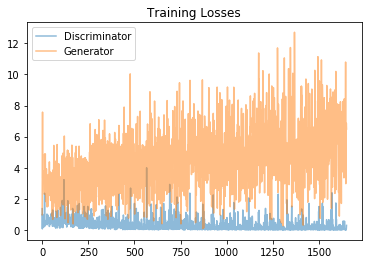

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

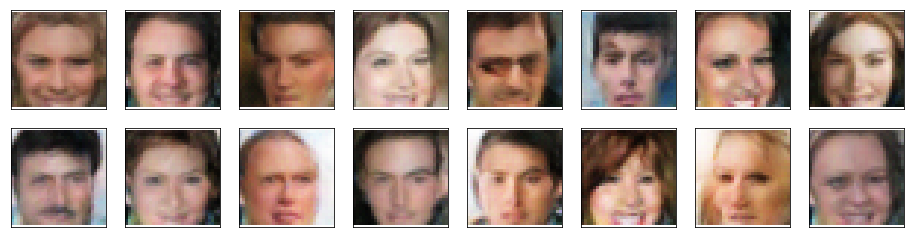

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** By looking at the result I see that gender is something the generator seem to tend to mix in the generated images. I guess it also try to mix people with sunglases and those who are not wearing sunglasses. About the training phase I see that the mean of the generator losses gradually increases instead of decreasing. For the Discriminator everything seems to be great. So, from the above stated I would:
- pay close attention to the images the model is learning from to have a variety but also that gender and accesories like sunglasses and hats do not perturb the outcome.
- try to adapt the depth of the network to the features of the images the model is learning from.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.